In [1]:
import random
import helpers
import numpy as np
import pandas as pd
from copy import copy
from genetic import Experiment,Population,Chromosome,Gen
from joblib import Parallel, delayed,parallel_backend
import time
from ExperimentBase import ExperimentBaseModel,Transformer,CAModel
from Visualization import Visualization
import matplotlib.pyplot as plt
import math

In [2]:
class Experiment1(ExperimentBaseModel):
    def __init__(self,data,name,path):
        ExperimentBaseModel.__init__(self,data,name,path)
    
    def setupChromosome(self,chromosome,goal):
        keys = list(self.domain.keys())
        keys = sorted(keys)
        for key in keys:
            noChoices = random.randint(0,len(self.domain[key])//2)
            vals = set(random.choices(self.domain[key],k=noChoices))
            chromosome.genes.append(Gen(key,vals))
    
    def mutate(self,chromosome):
        if random.random() < self.mutationRate:
            index = random.randint(0,len(chromosome.genes)-1)
            identifier = chromosome.genes[index].identifier
            proportion =  len(self.domain[identifier]) - len(chromosome.genes[index].value)
            if proportion < random.random():
                val = random.choice(self.domain[identifier])
                chromosome.genes[index].value.add(val)
            else:
                if len(chromosome.genes[index].value) > 0:
                    el = random.choice(list(chromosome.genes[index].value))
                    chromosome.genes[index].value.remove(el)
    
    def crossover(self,parent1,parent2,population):
        setup = lambda x: self.setupChromosome(x,population.goal)
        crossover = lambda p1,p2: self.crossover(p1,p2,population)
        chromosome = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome.parents = [parent1,parent2]
        iGenes = list(range(len(parent1.genes)))#list(self.domain.keys())
        random.shuffle(iGenes)
        mid = len(iGenes)//2
        genes = [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[:mid]]
        genes += [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[mid:]]
        chromosome.genes = sorted(genes,key=lambda x: x.identifier)
        return [chromosome]
    
    def express(self,chromosome):
        rule = "lambda x: sum(["
        terms = []
        for gen in chromosome.genes:
            vals = gen.value.difference(set([-1]))
            if len(vals) > 0 :
                terms.append("x[{}] in {}".format(gen.identifier,vals))
        if (len(terms) > 0):
            rule += " , ".join(terms) + "]) / {}".format(len(chromosome.genes))
        else:
            rule = "lambda x: 0"
        return rule
    
    def getTotalMatch(self,phenotype,goal):
        totalPosMatch = 0
        totalNegMatch = 0
        totalNeg = 0
        totalPos = 0
        matchProportion = eval(phenotype)
        for row in self.matrix:
            res = matchProportion(row[0])
            if row[2] == goal:
                totalPosMatch += res * row[1]
                totalPos += row[1]
            else:
                totalNegMatch -= res * row[1]
                totalNeg += row[1]
        totalExamples = totalNeg+totalPos
        posProp = (totalPos/totalExamples)
        negProp = (totalNeg/totalExamples)
        total = (totalPosMatch * negProp) + (totalNegMatch * posProp * 0.5)
        return total
    
    def setup(self):
        self.radious = 1
        self.neighborhood = helpers.moore([self.radious,self.radious])
        self.mutationRate = .2
        self.noChromosomes = 5
        self.noIterations = 100
        super().setup()

In [3]:
class Testing1():
    def __init__(self,data,model,verbose=0):
        self.data = data
        self.model = model
        self.verbose = verbose
    
    def testRow(self,row_prev,row,row_pred):
        totalMatch = 0
        total = 0
        for cell0,cell1,cell2 in zip(row_prev,row,row_pred):
            totalMatch += (cell0 != cell1 and cell1 == cell2)
            total += (cell0 != cell1)
        if total == 0:
            return [totalMatch,0]
        return [totalMatch,total]
            
    def run(self):
        res = []
        backend = "threading"
        with Parallel(n_jobs=4,backend=backend) as parallel:
            if self.verbose >= 1: print("Testing:")
            for i in range(1,len(data)):
                if self.verbose >= 1: print(f"state {i}/{len(data)}")
                prediction = next(model.run(data[i-1],1))
                rowsTotal = parallel(delayed(self.testRow)(row0,row1,row2) for row0,row1,row2 in zip(data[i-1],data[i],prediction[1]))
                summation = np.sum(rowsTotal,axis=0)
                if self.verbose >= 1: print(summation)
                total = summation[0]/summation[1] if summation[1] > 0 else 0
                res.append(total)
        self.result = res
    
    def plot(self):
        plt.plot(range(len(self.result)),self.result)
        return plt

dataframe = pd.read_csv("data/2_square.csv")
data  = dataframe.values
exp = Experiment1(data,"Experiment1","path")
exp.run()

In [4]:
data  = np.array([[[0,1],[1,2]],[[1,2],[2,0]],[[2,0],[0,1]],[[0,1],[1,2]]])#np.load("data/wildfire.npy")
train = len(data)#math.floor(len(data) * 0.8)
exp2 = Experiment1(data[:train],"Experiment2","small1")
exp2.run()

start setup
Start 1 (2, 2)Start 2 (2, 2)

Start 3 (2, 2)
middle 0.1101980209350586middle 0.11110806465148926
End 1 0.11127805709838867

End 2 0.11104989051818848
middle 0.10971808433532715
End 3 0.11003613471984863
0.2148139476776123
0.4219779968261719
end setup
config saved at small1/08_01_20_17_51_12/config.json


In [5]:
transformer = Transformer(exp2)
model = transformer.getModel()

In [6]:
prediction = []
for it in model.run(data[0],10):
    prediction.append(it[1])

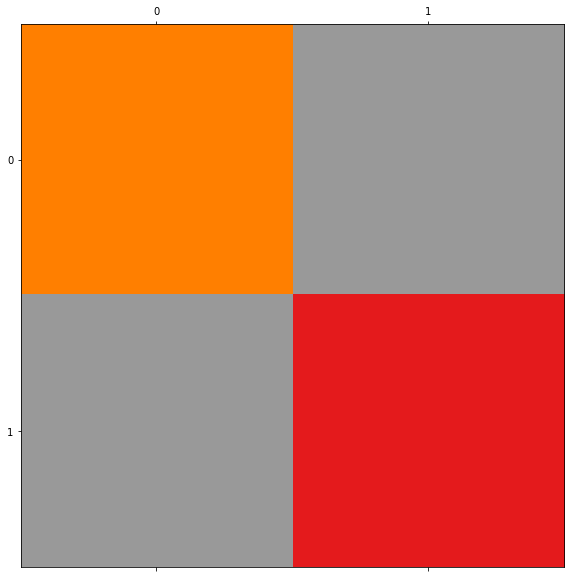

In [7]:
helpers.animate(prediction)

Testing:
state 1/4
[0 4]
state 2/4
[1 4]
state 3/4
[0 4]


<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

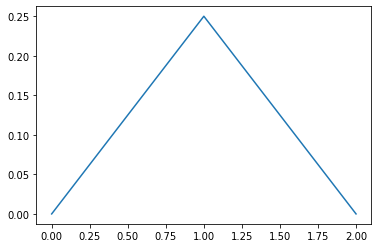

In [29]:
test1 = Testing1(data,model,verbose=1)
test1.run()
test1.plot()

In [24]:
visualization = Visualization("small1/16_12_19_12_04_43")

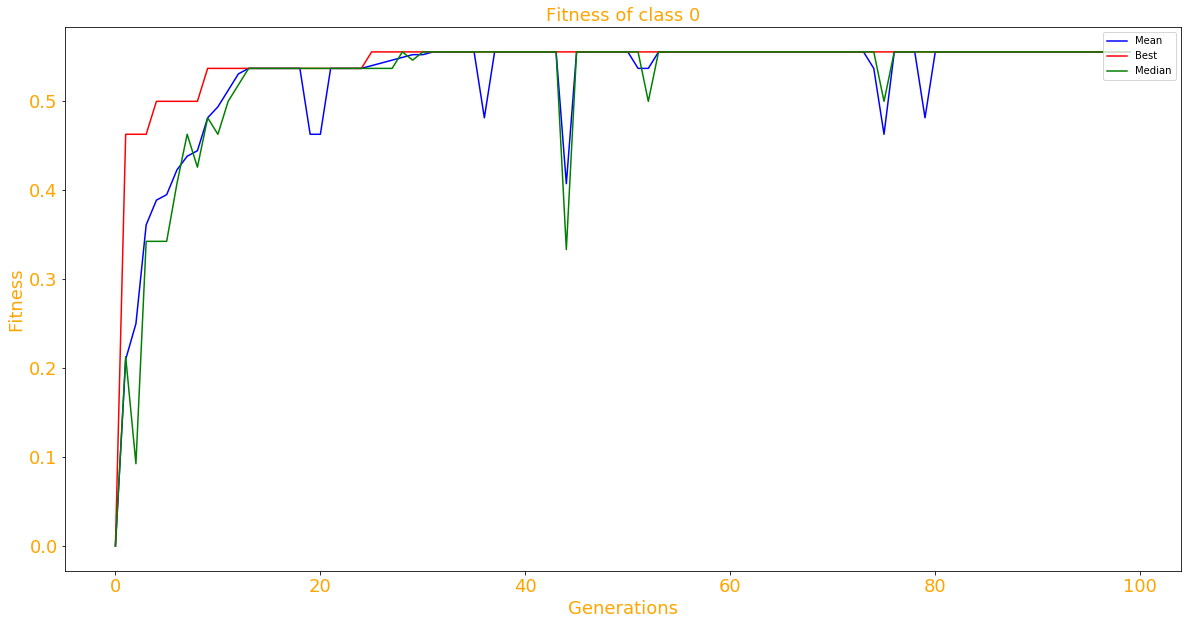

In [25]:
visualization.getFitnessGraph("0")

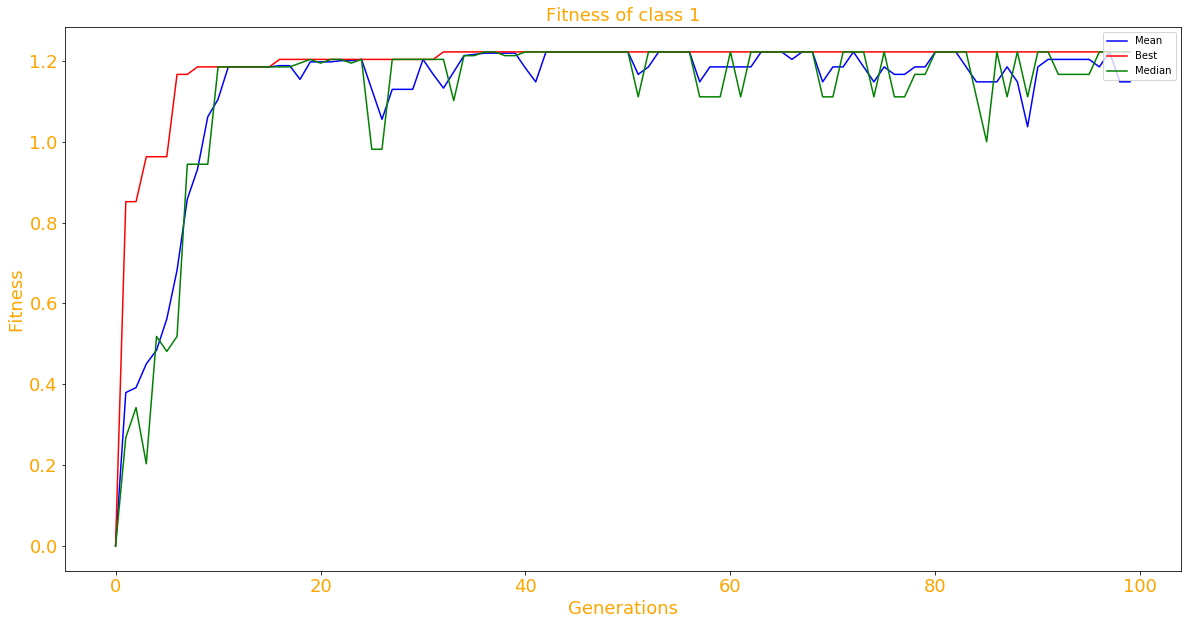

In [26]:
visualization.getFitnessGraph("1")

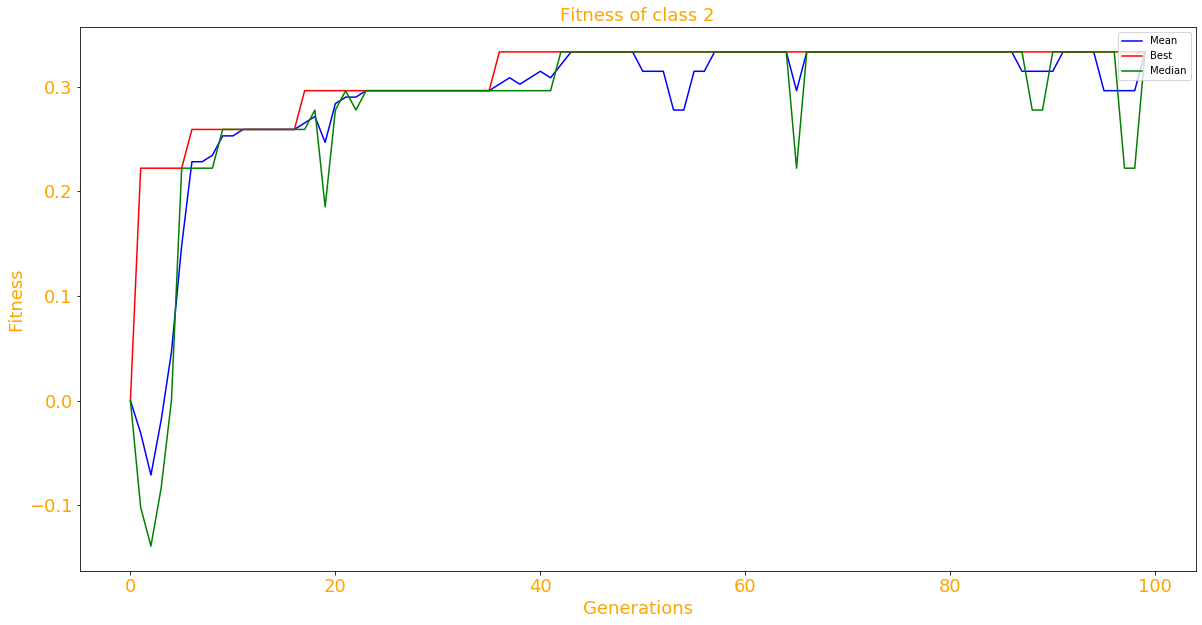

In [27]:
visualization.getFitnessGraph("2")

In [13]:
transformer.lmstr

{0: 'lambda x: x[0] in {0} and x[4] in {2}',
 2: 'lambda x: x[3] in {0} and x[8] in {0}',
 1: 'lambda x: x[0] in {1} and x[1] in {2} and x[4] in {0} and x[5] in {1} and x[7] in {1}'}

In [ ]:
exp2.world.toDict()